# P3. End to End Machine Learning  
  
### Setup 

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import tarfile
import urllib
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### Download the data
Download and store the tgz file and extract it on the same location of the notebook and sub folders 'datasets/housing'. 

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
data = load_housing_data()
data.head() # Display the top five rows of the dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Some parts of the lab were skipped here. 

### Create a Test Set
The test data will be used later to test the classifier, pick some instances randomly (typically 20% of the dataset). 

In [6]:
# Make the notebook's output identical at every run.
np.random.seed(42)

Let's code the `train_test_split()` method by hand!

In [7]:
def split_train_test(data, test_ratio):
    shuffled = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled[:test_set_size]
    train_indeces = shuffled[test_set_size:]
    return data.iloc[train_indeces], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_test(data, 0.2)
train_set.shape

(16512, 10)

In [9]:
test_set.shape

(4128, 10)

<AxesSubplot:>

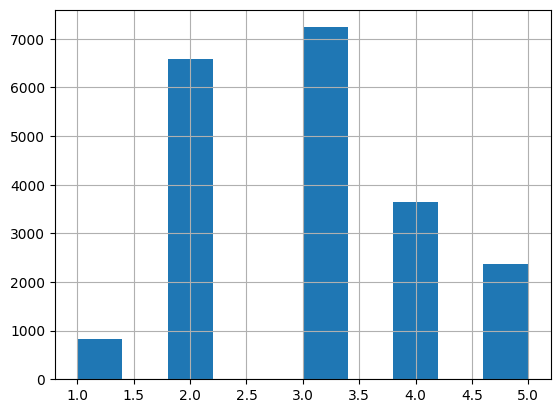

In [10]:
data["income_cat"] = pd.cut(data["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
data['income_cat'].hist()

Stratified sampling based on the income category, to generate the test set with income category proportions almost identical to those in the full dataset. 

In [11]:
# Provides train/test indices to split data in train/test sets. 
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [12]:
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

### Data Preprocessing
Prepare the data for Machine Learning Algorithms. 

In [13]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Custom Transformer:

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [18]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3,6.096552,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.09,<1H OCEAN,4,6.658342,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,2,5.571932,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,3,4.110465,2.662791
19140,-122.7,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,3,6.297405,2.411178


### Transformation Pipelines
[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) <- Important to learn Documentation Link

There are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) <- Important to learn Documentation Link

Standardization used in numerical data preparation, first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance.

In [20]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,3


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),  # Dealing with missing values.
        ('attribs_adder', CombinedAttributesAdder()),  # New attribute.
        ('std_scaler', StandardScaler()),             # Attribute normalization.
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr.shape

(16512, 12)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

[ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) <- Important to learn Documentation Link

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),  # Apply the numerical transformation to the all numeric columns.
        ("cat", OneHotEncoder(), cat_attribs),  # Apply the One Hot Encoding to the all categorical. columns
    ])

housing_prepared = full_pipeline.fit_transform(housing)  # Now fit_transform applies all the transformation to the data.
housing_prepared.shape  # More columns than before because of one-hot encoding. 

(16512, 17)

### Select and Train a Model 
You will use some regression models:
- Linear Regression
- Decision Tree Regression
- Random Forest Regressor
- Support Vector Regression

### Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression()
lr_clf.fit(housing_prepared, housing_labels)

LinearRegression()

In [31]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lr_clf.predict(some_data_prepared))

Predictions: [ 83804. 314380. 145628. 183700. 238728.]


In [32]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [33]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 , -0.95468705,  0.01739526,
         0.00622264, -0.12112176,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  1.89007821,  0.56925554,
        -0.04081077, -0.81086696,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.95468705, -0.01802432,
        -0.07537122, -0.33827252,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.95468705, -0.59513997,
        -0.10680295,  0.96120521,  0.        ,  0.        ,  0.        ,
         0.        

#### Mean Squared Error

In [34]:
from sklearn.metrics import mean_squared_error

housing_predictions = lr_clf.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.51631166147

#### Mean Absolute Error

In [35]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49507.0492369186

### Decision Tree Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [37]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Evaluation using Cross-Validation

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    tree_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10
)
tree_rmse_scores = np.sqrt(-scores)

In [39]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72237.45096271 69208.53094621 69286.11573206 70612.13634405
 70577.30202088 76840.97092314 71823.83279699 72710.22512908
 67780.77127665 71678.17802175]
Mean: 71275.55141535088
Standard deviation: 2362.02756776275


In [40]:
lin_scores = cross_val_score(lr_clf, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71519.9505082  64044.46774989 67454.97869698 68513.98096316
 66303.72216081 72175.95711253 74407.90738867 68585.11831982
 66063.64175868 69871.13996366]
Mean: 68894.08646223915
Standard deviation: 2992.8894142481904
